In [104]:
# %matplotlib widget
# %matplotlib inline
%matplotlib qt5

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq
import Pyro4.util

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [5]:
# expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_241025')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_241025


In [6]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_path = os.path.join(os.getcwd(), config_file)

# config_file = 'config.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)

print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [7]:
import yaml
print('Using config file', config_path)
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

Using config file s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


In [8]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
# im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
im = InstrumentManager(ns_address='10.108.30.75') # Spilker Vibranium
# print(im)
print(im.keys())

dict_keys(['Pyro.NameServer', 'Qick_QRAM'])


In [9]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Sat Oct  5 10:21:47 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
# lo1 = SignalCore(name="SignalCore", address='10003494')
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# print(lo1.get_device_status().pll_status.crs_pll_ld)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# # lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# # lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo_freq = 4385.5e6
# lo_power = 14
# lo1.set_frequency(lo_freq) # Set LO frequency
# print(f'set lo freq to {lo_freq*1e-6} MHz')
# lo1.set_power(lo_power) # Set LO power
# print(f'set lo power to {lo_power} dBm')

# Single qubit RB

In [11]:
qubit_i = 2
# qubits = [2, 1]
# qubit_i = qubits[0]

step 20
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.95193842109995, 5794.90833333, 501.288233333334, -229.94910723], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.25, 0.3, 0.85, 0.35], 'readout_length': [8.0, 10.0, 7.0, 6.0], 'readout_length_ef': [8.0, 7.0, 4.0, 4.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4110.428247950795, 4105.038816552946, 4110.198576889643, 4109.933722963169, 3442.8436398119666, 3448.2234633901926, 3447.122665677232, 3446.8985639748066, 4762.066958508102, 4761.098043820929, 4762.201572322125, 4761.678033261405, 4381.167436176662, 4380.365504198304, 4381.142621732222, 4381.679544300405], 'f_ef': [3884.3737933985267, 0.0, 0.0, 0.0, 0.0, 3347.761789059698, 0.0, 0.0, 4571.9056482340775, 4570.482481434396, 4572.387578885567, 0.0, 4211.706921103304, 4207.262930371132, 0.0, 4209.981140744554], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999]

  0%|          | 0/2 [00:00<?, ?it/s]

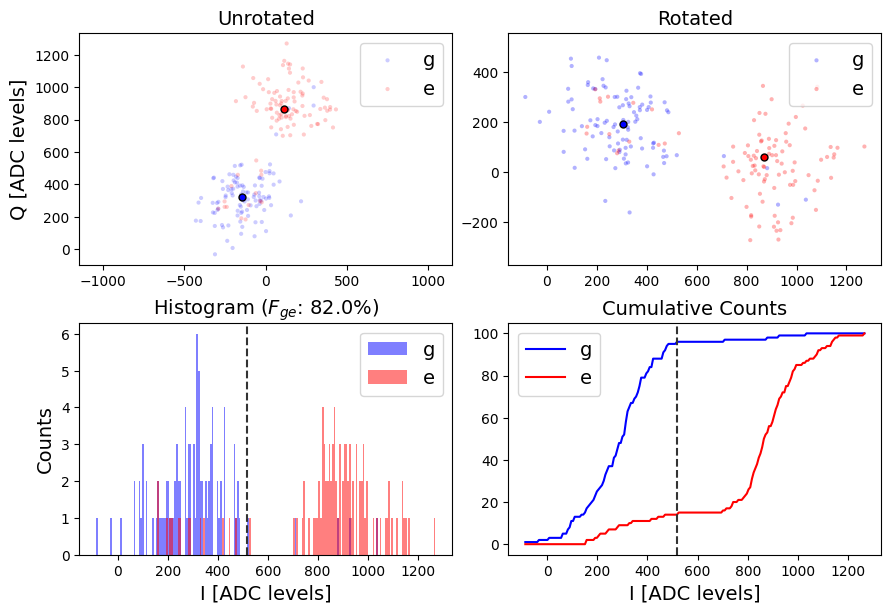

thresholds=[0, 0, 517.9565194773803, 0],
angles=[0, 0, -79.53534652695703, 0],
ge_avgs=[[0, 0, 0, 0], [0, 0, 0, 0], [-128.4941906976744, 333.5667162790698, 103.54448837209306, 820.5909116279072], [0, 0, 0, 0]] ,
counts_calib=[[95.0, 5.0], [14.0, 86.0]]


  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
rbprog = meas.SimultaneousRBExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb1Q_qubit{qubit_i}",
    config_file=config_path,
)

gate_char = None
# gate_char = 'X'

# max_gates = 225

max_gates = 100
# expts = 30
expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)


rbprog.cfg.expt = dict(
    # start=1, # rb depth start
    start=34, # rb depth start
    step=step, # step rb depth
    # step=5, # step rb depth
    # expts=expts, # number steps
    expts=1, # number steps
    reps=5000, # number averages per unique sequence
    variations=3, # number different sequences per depth
    gate_char=None, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=[qubit_i], # the qubits to perform simultaneous RB on (if eg-gf, q should be qA != 1)
    # qubits=qubits,
    # qDrive=qubits[0],
    # singleshot_reps=20000, # reps per state for singleshot calibration
    singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    # thresholds=[0, 613.9114184246247, 507.47891189954305, 0],
    # angles=[0, -101.54512016437148, 72.02480620589141, 0],
    # ge_avgs=[array([0., 0., 0., 0.]), [-101.85060937209302, 466.51286116279067, -154.72153951162792, 742.5887439767441], [21.863250678241997, -256.37994772110693, 120.73579574064026, -794.2915984536081], array([0., 0., 0., 0.])],
    # counts_calib=[[16238, 3110, 527, 125], [3374, 16034, 95, 497], [1968, 395, 14344, 3293], [494, 2404, 2838, 14264]]
)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
rbprog.analyze(fit=True)
rbprog.display(fit=True, qubit=[qubit_i])

In [ ]:
p_irb = 0.913
p_rb = 0.949  
print(100*meas.fitting.rb_error(p_rb, 2),'% average error')
print(100*(1-meas.fitting.rb_gate_fidelity(p_rb, p_irb, 2)), '% gate error')

In [ ]:
qDrive = qubits[0]
setup_ZZ = 0

In [ ]:
rbprog.save_data()

### EF RB

In [22]:
qubit_i = 3

ZZ_qubit = 0 # for initialization
# ZZ_qubit = None

test_qZZ = ZZ_qubit

step 3
running 1 loops


  0%|          | 0/3 [00:00<?, ?it/s]

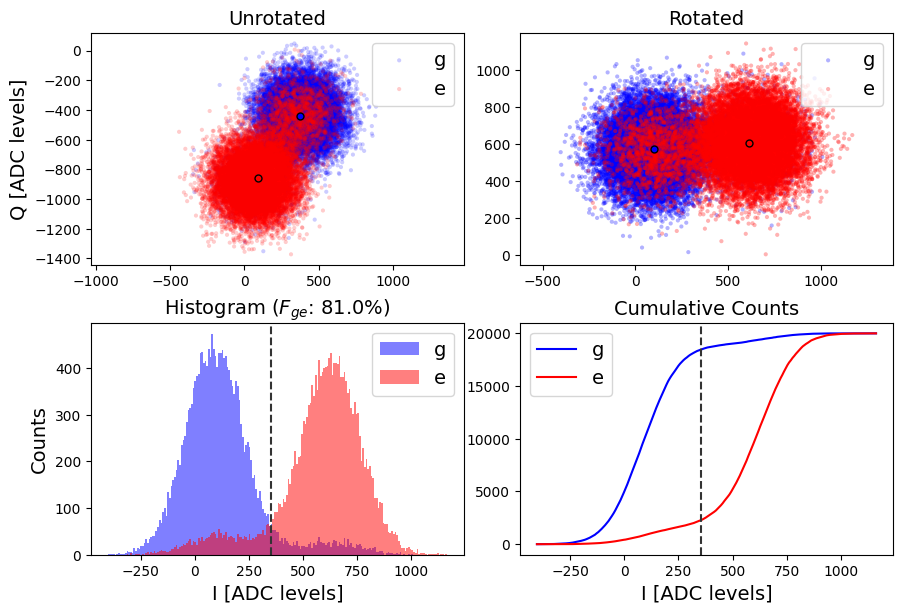

thresholds=[0, 0, 0, 351.71596562623955],
angles=[0, 0, 0, 129.29233678903194],
ge_avgs=[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [365.887408220293, -457.7089064568638, 100.91732004883343, -833.6900771296799]] ,
thresholds=[0, 0, 0, 351.71596562623955],
angles=[0, 0, 0, 129.29233678903194],
ge_avgs=[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [365.887408220293, -457.7089064568638, 100.91732004883343, -833.6900771296799]],
counts_calib=[[18389.0, 1611.0], [2198.0, 17802.0], [1684.0, 18316.0]]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Qubit (3) f


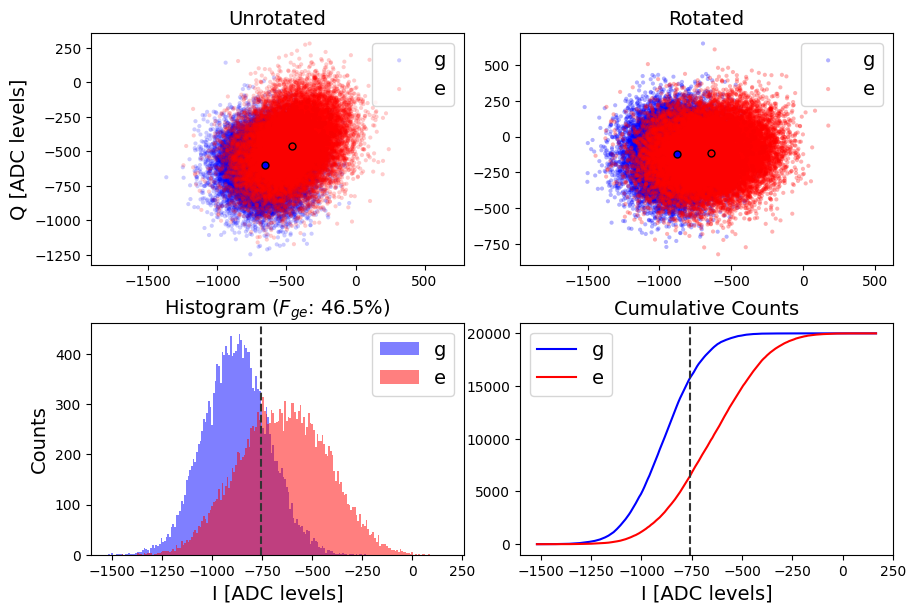

gf fidelity (%): 46.5361634040851
thresholds_f=[0, 0, 0, -757.0838505155868],
angles_f=[0, 0, 0, -34.37929590946284],
gf_avgs=[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), [-653.844522253865, -600.27864182262, -465.3276626118796, -460.3529818551668]],
counts_calib_f=[[15526.0, 4474.0], [15572.0, 4428.0], [6263.0, 13737.0]]


  0%|          | 0/31 [00:00<?, ?it/s]

In [36]:
rbprog = meas.SimultaneousRBEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb1Q_qubit{qubit_i}",
    config_file=config_path,
)

# gate_char = None
gate_char = 'X'

max_gates = 225
# max_gates = 100
# max_gates = 150
# max_gates = 40

expts = 30
# expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)

rbprog.cfg.expt = dict(
    start=1, # rb depth start
    # start=200, # rb depth start
    step=step, # step rb depth
    # expts=1, # number steps
    expts=expts+1, # number steps
    reps=2000, # number averages per unique sequence
    reps_f=5000,
    # reps=200, # number averages per unique sequence
    # reps_f=500,
    loops=1,
    variations=15, # number different sequences per depth
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=[qubit_i], # the qubits to perform simultaneous RB on (if eg-gf, q should be qA != 1)
    ZZ_qubit=ZZ_qubit,
    test_qZZ=test_qZZ,
    # qubits=qubits,
    # qDrive=qubits[0],
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None
    measure_f=[qubit_i],

)

# print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [37]:
rbprog.save_data()

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00006_rb1Q_qubit3.h5


'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00006_rb1Q_qubit3.h5'

counts calib total shape (1, 3, 4)
counts raw shape (1, 31, 15, 4) (loops, depths, variations, 4)
[ 213.  1787.  1531.6  468.4]


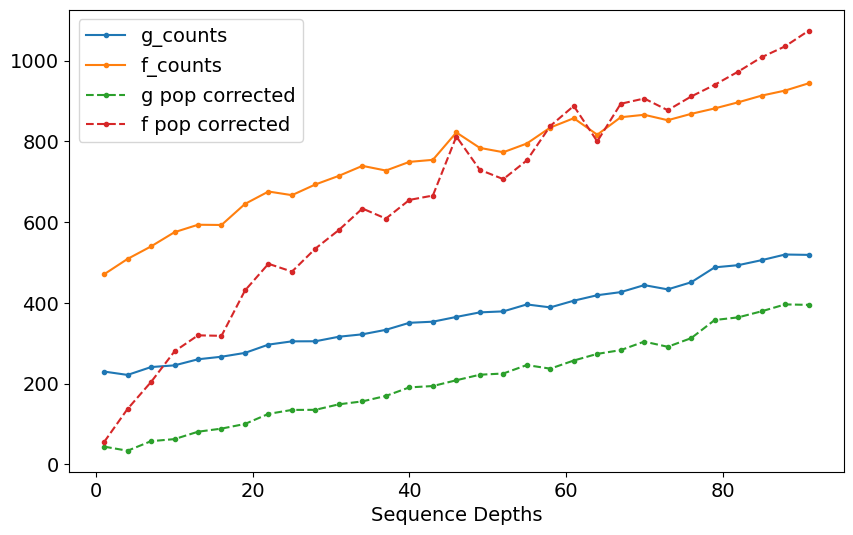

fit1 p1, a, offset [9.97785580e-01 9.89879811e-01 1.01866809e-16]
fit2 a0, b0, c0, p2 [2.43464567e-22 1.61032580e-13 9.50459544e-01 9.87525380e-01]
Running interleaved X gate RB on EF subspace
Depolarizing parameter p1 from fit: 0.9977855803667451 +/- 0.000916156777186585
Running interleaved X gate RB on EF subspace
Depolarizing parameter p2 from fit: 0.9875253797995719 +/- 0.0018098363377453284
Fidelity: 0.9926554800831586 +/- 1.6906690179134695e-06
Leakage L1: 0.00221441963325486
Seepage L2: 2.2557586136987885e-19
Depolarizing parameter p from e/subspace fit: 0.9896350266866283 +/- 0.0018075917045858431
Average RB gate error on e/subspace: 0.0051824866566858585 +/- 0.0009037958522929216
	Fidelity of e/subspace=1-error: 0.9948175133433141 +/- 0.0009037958522929216


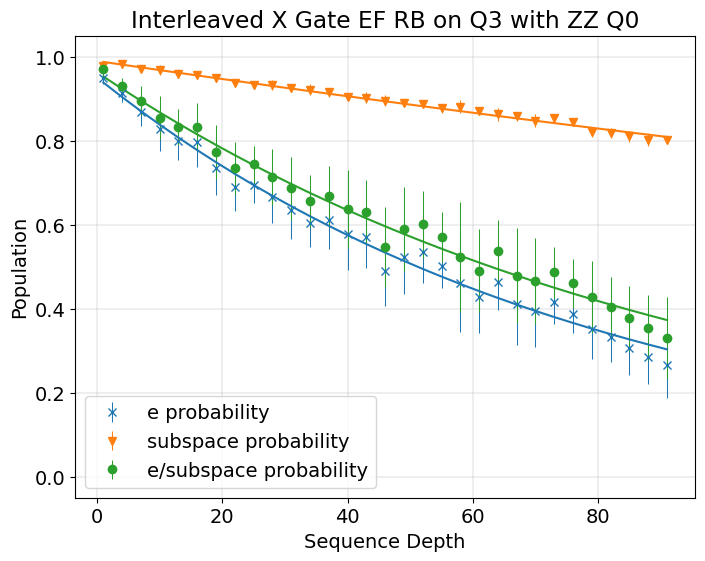

In [38]:
rbprog.analyze(fit=True, separate_correction=True)
rbprog.display(fit=True, show_all_vars=False)

# SWAP RB

## Calibrate swap phase

In [28]:
swap_qubit = 2

# ZZ_qubit = 0 # for tomography pulses
ZZ_qubit = None

test_pi_half = False

use_IQ_pulse = False
use_robust_pulses = True
full_mux_expt = True
resonator_reset = [0, 2, 3]

In [29]:
phaseprog = meas.EgGfPhaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"EgGfPhaseCalib{swap_qubit}",
    config_file=config_path,
)

n_pulses = 8
# n_pulses = 2
if test_pi_half: n_pulses *= 2

qubit = 1

start = 0
span = 180
npts = 10

print('step size', span/npts)

phaseprog.cfg.expt = dict(
    start_phase=start,
    step_phase=span/npts,
    expts_phase=npts+1,
    reps=10000,
    singleshot_reps=10000,
    # singleshot_reps=100,
    swap_qubit=swap_qubit,
    test_pi_half=test_pi_half,
    n_pulses=n_pulses,
    qubit=qubit,
    use_IQ_pulse=use_IQ_pulse,
    use_robust_pulses=use_robust_pulses,
    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
)
for q in range(4):
    if q != qubit:
        phaseprog.cfg.device.readout.gain[q] = 1e-4

# print(phaseprog.cfg)

import Pyro4.util
try:
    phaseprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

step size 18.0


  0%|          | 0/2 [00:00<?, ?it/s]

ge fidelity (%): 50.299999999999976 	 angle (deg): 0.0 	 threshold ge: 1172.0014727229668
thresholds=[0, 1172.0014727229668, 0, 0],
angles=[0, 0.0, 0, 0],
ge_avgs=[ 963.15142482    0.         1377.20431961    0.        ] ,
counts_calib=[[7610.0, 2390.0], [2583.0, 7417.0]]


  0%|          | 0/11 [00:00<?, ?it/s]

In [24]:
phaseprog.save_data()

Saving S:\QRAM\qram_4QR2\data\data_241025\00000_EgGfPhaseCalib3.h5


'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00000_EgGfPhaseCalib3.h5'

In [30]:
if swap_qubit == 2:
    target_X_counts = [1, 0]
elif swap_qubit == 3:
    target_X_counts = [0.78406, 0.21594]
else:
    assert False

phaseprog.analyze(target_X_counts=target_X_counts)
phaseprog.display()

target X pop 0.0
phase adjust for 1 pi swap: 180.0 deg


## Calibrate phase between X/2 and X

In [24]:
qubits = [2, 1]
qDrive = 2

# ZZ_qubit = 0 # for tomography pulses
ZZ_qubit = None

test_pi_half = False

use_IQ_pulse = False
use_robust_pulses = True
full_mux_expt = True
resonator_reset = [0, 2, 3]

In [28]:
phaseprog = meas.EgGfX_Xhalf_PhaseCalib_Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"EgGfX_Xhalf_PhaseCalib{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

n_cycles = 16

qubit = 1

start = 0
span = 180
npts = 15

print('step size', span/npts)

phaseprog.cfg.expt = dict(
    start=start,
    step=span/npts,
    expts=npts+1,
    reps=5000,
    loops=1,
    singleshot_reps=10000,
    # singleshot_reps=100,
    n_cycles=n_cycles,

    post_process=None,
    measure_f=False,
    qDrive=qDrive,
    qubits=qubits,

    use_IQ_pulse=use_IQ_pulse,
    use_robust_pulses=use_robust_pulses,
    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
)
for q in range(4):
    if q not in qubits:
        phaseprog.cfg.device.readout.gain[q] = 1e-4

# print(phaseprog.cfg)

import Pyro4.util
try:
    phaseprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

step size 12.0


  0%|          | 0/16 [00:00<?, ?it/s]

In [29]:
phaseprog.display(fit=False)

## Run RB

### Test RB

In [222]:
# qubits = [2, 1]
# qDrive = 2

qubits = [3, 1]
qDrive = 3

full_mux_expt = False
resonator_reset = [0, 2, 3] if full_mux_expt else None

In [223]:
# step_sb = 15
# end_sb = 100

# step_leak = 15
# end_leak = 300
# sb = np.arange(1, end_sb+step_sb, step_sb)
# lk = np.arange(sb[-1]+step_leak, end_leak+step_leak, step_leak)
# depths = np.concatenate((sb, lk))
# print('depths', len(depths))
# print(depths)


depths = [1, 30, 200]

In [226]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

gate_char = None
# gate_char = 'X'


# # expts = 30
# # expts = 19
# expts = 10

# # if gate_char is None: max_gates = 500
# if gate_char is None: max_gates = 100
# else: max_gates = 300

# step = max_gates // expts
# step = 10
# print('step', step)

rbprog.cfg.expt = dict(
    depths=depths,

    # variations=20,
    variations=3,

    # reps=3000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    # reps_f=3000,
    reps=1000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    # reps_f=1000000,
    # reps=100,
    loops=4,
    # loops=1,
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=10000, # reps per state for singleshot calibration
    # singleshot_reps_f=15000, # reps per state for singleshot calibration
    # singleshot_reps=800, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f_only=False,
    measure_f=[qDrive],
    add_phase=True,

    # cool_qubits=[0, 1],

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,

    validate_variations=False,

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.acquire(progress=True, debug=True)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-389.975, 5795.761666663333, 502.368233333334, -228.9], 'gain': [0.5, 0.6, 0.4, 0.3], 'readout_length': [5, 20, 10, 8], 'frequency_ef': [-391.91408405, 5795.76166666, 500.44439227, -230.30732892], 'gain_ef': [0.05, 0.6, 0.4, 0.25], 'readout_length_ef': [1, 20, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.144520031796, 4105.783958808882, 4111.0028964412795, 4110.5966963096635, 3442.9795552267146, 3448.3482722012286, 3447.233490336077, 3447.0285717924894, 4762.767009306428, 4761.793655204115, 4762.900421466317, 4762.367822139689, 4380.662337410765, 4379.890920412824, 4380.6668186549305, 4381.2810527960755], 'f_ef': [3885.3117884920853, 0.0, 0.0, 0.0, 0.0, 3347.8480888529375, 0.0, 0.0, 4571.9056482340775, 4571.070566218902, 4572.9717022650675, 0.0, 4211.573193413508, 4207.17517228526, 0.0, 4209.900559061916], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q_half': 

  0%|          | 0/4 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 77.94925192519254 	 angle (deg): 18.24402852609133 	 threshold ge: 65.02828830236082
Qubit (3) ge
ge fidelity (%): 69.50000000000003 	 angle (deg): 72.37508406115987 	 threshold ge: 57.64930629829425
thresholds=[0, 65.02828830236082, 0, 57.64930629829425],
angles=[0, 18.24402852609133, 0, 72.37508406115987],
ge_avgs=[array([0., 0., 0., 0.]), array([ 43.00847822,  -1.80781263,  91.33006536, -17.73629884]), array([0., 0., 0., 0.]), array([ 64.34772274, -11.09076432,  82.05792567, -66.8362764 ])],
counts_calib=[[7976, 1237, 630, 157], [1552, 7662, 105, 681], [1173, 247, 7281, 1299], [330, 1340, 1383, 6947], [1137, 7059, 113, 1691], [282, 1146, 1024, 7548]]


  0%|          | 0/3 [00:00<?, ?it/s]

depth 0
depth 1
depth 2


  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 77.69953895389541
Qubit (3) gf
gf fidelity (%): 50.10000000000001
thresholds_f=[0, 64.8943882302122, 0, -74.45858687827909],
angles_f=[0, 15.903393727156452, 0, 72.15521825138654],
gf_avgs=[array([0., 0., 0., 0.]), array([ 40.55179591,  -3.27718091,  88.75499178, -17.01130934]), array([0., 0., 0., 0.]), array([ 13.22976526, 106.17975435,  23.65267282,  73.80316123])],
counts_calib_f=[[7996, 1499, 454, 51], [7920, 1397, 590, 93], [1416, 321, 6792, 1471], [1410, 282, 7133, 1175], [3159, 6082, 286, 473], [777, 788, 2974, 5461]]


  0%|          | 0/3 [00:00<?, ?it/s]

Beginning loop 1


  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 77.5192509250925 	 angle (deg): 17.745741229888583 	 threshold ge: 64.52623230152838
Qubit (3) ge
ge fidelity (%): 68.42838183818385 	 angle (deg): -25.627803326068946 	 threshold ge: 54.226920033435164
thresholds=[0, 64.52623230152838, 0, 54.226920033435164],
angles=[0, 17.745741229888583, 0, -25.627803326068946],
ge_avgs=[array([0., 0., 0., 0.]), array([ 43.18178394,  -2.07472629,  90.09448374, -17.08775568]), array([0., 0., 0., 0.]), array([ 0.22841542, 67.2468443 , 51.80766225, 91.99026078])],
counts_calib=[[7818, 1391, 595, 196], [1455, 7528, 130, 887], [1186, 273, 7222, 1319], [294, 1195, 1401, 7110], [1153, 7578, 94, 1175], [283, 1150, 1024, 7543]]


  0%|          | 0/3 [00:00<?, ?it/s]

depth 2
depth 1
depth 0


  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 77.20000000000002
Qubit (3) gf
gf fidelity (%): 49.68000000000003
thresholds_f=[0, 64.2470918216381, 0, -71.45366693722801],
angles_f=[0, 16.191924533235028, 0, 148.83438175695798],
gf_avgs=[array([0., 0., 0., 0.]), array([ 40.53720609,  -2.83290627,  88.35321208, -16.71743229]), array([0., 0., 0., 0.]), array([105.09269272,   8.28008442,  76.92394308,  -8.75642201])],
counts_calib_f=[[8025, 1440, 480, 55], [7893, 1383, 631, 93], [1438, 313, 6945, 1304], [1460, 261, 7198, 1081], [3235, 5928, 329, 508], [810, 839, 3040, 5311]]


  0%|          | 0/3 [00:00<?, ?it/s]

Beginning loop 2


  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 75.36942994299433 	 angle (deg): 16.80378327925657 	 threshold ge: 64.18795375071225
Qubit (3) ge
ge fidelity (%): 69.02866886688668 	 angle (deg): -104.65322359797334 	 threshold ge: 56.15597849059552
thresholds=[0, 64.18795375071225, 0, 56.15597849059552],
angles=[0, 16.80378327925657, 0, -104.65322359797334],
ge_avgs=[array([0., 0., 0., 0.]), array([ 41.56026883,  -2.10983026,  87.03617541, -15.84309253]), array([0., 0., 0., 0.]), array([-65.59814646,  12.71514414, -80.04465386,  67.96568564])],
counts_calib=[[8131, 1248, 487, 134], [1583, 7444, 134, 839], [1578, 281, 6973, 1168], [328, 1427, 1246, 6999], [1160, 7130, 129, 1581], [276, 1074, 1103, 7547]]


  0%|          | 0/3 [00:00<?, ?it/s]

depth 0
depth 1
depth 2


  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 77.77952095209521
Qubit (3) gf
gf fidelity (%): 46.48999999999999
thresholds_f=[0, 64.43416945008384, 0, -69.58018267113397],
angles_f=[0, 16.687675220845428, 0, 125.78020019029096],
gf_avgs=[array([0., 0., 0., 0.]), array([ 39.90628446,  -2.65457979,  89.25349233, -17.44788198]), array([0., 0., 0., 0.]), array([93.12277209, 46.4112812 , 74.87269028, 21.08847864])],
counts_calib_f=[[7982, 1503, 432, 83], [8044, 1201, 653, 102], [1465, 251, 7247, 1037], [1512, 264, 7250, 974], [3466, 5760, 302, 472], [782, 755, 3167, 5296]]


  0%|          | 0/3 [00:00<?, ?it/s]

Beginning loop 3


  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 76.42999999999999 	 angle (deg): 16.727155068089807 	 threshold ge: 62.45451349002933
Qubit (3) ge
ge fidelity (%): 71.48871287128712 	 angle (deg): -82.06532750849621 	 threshold ge: 56.66273536482089
thresholds=[0, 62.45451349002933, 0, 56.66273536482089],
angles=[0, 16.727155068089807, 0, -82.06532750849621],
ge_avgs=[array([0., 0., 0., 0.]), array([ 41.45145257,  -1.62422318,  88.30264132, -15.7044604 ]), array([0., 0., 0., 0.]), array([-54.66302478,  36.25729882, -46.36236041,  95.81221648])],
counts_calib=[[8103, 1179, 573, 145], [1416, 7546, 112, 926], [1408, 252, 7271, 1069], [271, 1218, 1223, 7288], [1103, 7286, 131, 1480], [249, 1110, 987, 7654]]


  0%|          | 0/3 [00:00<?, ?it/s]

depth 2
depth 1
depth 0


  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 77.9395709570957
Qubit (3) gf
gf fidelity (%): 49.910000000000004
thresholds_f=[0, 66.36171265056483, 0, -74.32010982576969],
angles_f=[0, 16.101538154662638, 0, -30.239330607017447],
gf_avgs=[array([0., 0., 0., 0.]), array([ 40.70200176,  -3.15181927,  89.37540869, -17.20209185]), array([0., 0., 0., 0.]), array([-106.68066566,  -10.66784475,  -77.28114675,    6.47011212])],
counts_calib_f=[[8146, 1393, 406, 55], [8113, 1225, 589, 73], [1474, 273, 7047, 1206], [1512, 247, 7233, 1008], [3293, 6073, 269, 365], [780, 827, 3134, 5259]]


  0%|          | 0/3 [00:00<?, ?it/s]

In [227]:
# # TESTING
# rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00011_rb_EgGf_qubit31.h5')
# rbprog.data = temp_data
# rbprog.cfg = AttrDict(attrs['config'])
# rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
rbprog.display(fit=False, show_all_vars=False)

[  1.  30. 200.]
counts calib total shape (4, 6, 8)
[[[7976 1237  630  157 7996 1499  454   51]
  [1552 7662  105  681 7920 1397  590   93]
  [1173  247 7281 1299 1416  321 6792 1471]
  [ 330 1340 1383 6947 1410  282 7133 1175]
  [1137 7059  113 1691 3159 6082  286  473]
  [ 282 1146 1024 7548  777  788 2974 5461]]

 [[7818 1391  595  196 8025 1440  480   55]
  [1455 7528  130  887 7893 1383  631   93]
  [1186  273 7222 1319 1438  313 6945 1304]
  [ 294 1195 1401 7110 1460  261 7198 1081]
  [1153 7578   94 1175 3235 5928  329  508]
  [ 283 1150 1024 7543  810  839 3040 5311]]

 [[8131 1248  487  134 7982 1503  432   83]
  [1583 7444  134  839 8044 1201  653  102]
  [1578  281 6973 1168 1465  251 7247 1037]
  [ 328 1427 1246 6999 1512  264 7250  974]
  [1160 7130  129 1581 3466 5760  302  472]
  [ 276 1074 1103 7547  782  755 3167 5296]]

 [[8103 1179  573  145 8146 1393  406   55]
  [1416 7546  112  926 8113 1225  589   73]
  [1408  252 7271 1069 1474  273 7047 1206]
  [ 271 1218 1223 

  0%|          | 0/3 [00:00<?, ?it/s]

minimization error 0.031199415407656708
counts raw [0.103 0.051 0.714 0.132 0.122 0.032 0.725 0.121]
counts_corrected [[-5.99136967e-17  2.42943763e-17  9.76846640e-01  2.31533596e-02
   5.58215580e-17  4.96318728e-18]]
minimization error 0.004887688924470651
counts raw [0.117 0.049 0.686 0.148 0.142 0.047 0.646 0.165]
counts_corrected [[ 1.01038235e-03  7.13139576e-04  9.36388970e-01 -2.25089397e-17
   2.62161504e-02  3.56713579e-02]]
minimization error 0.018319555919799054
counts raw [0.114 0.053 0.72  0.113 0.163 0.048 0.671 0.118]
counts_corrected [[2.25394223e-17 2.47919782e-02 9.72019660e-01 4.55186832e-17
  3.18836225e-03 1.15272123e-17]]
minimization error 0.012199011359615068
counts raw [0.215 0.258 0.379 0.148 0.366 0.125 0.433 0.076]
counts_corrected [[ 1.35045132e-01  1.87464985e-01  4.95478009e-01  8.62832734e-02
   9.57286010e-02 -2.49914568e-17]]
minimization error 0.01641297293008148
counts raw [0.204 0.263 0.395 0.138 0.344 0.113 0.45  0.093]
counts_corrected [[ 1.0769

  0%|          | 0/3 [00:00<?, ?it/s]

minimization error 0.028995363196485494
counts raw [0.126 0.047 0.727 0.1   0.116 0.053 0.674 0.157]
counts_corrected [[ 7.82349932e-18  1.62411088e-17  9.83617267e-01 -1.02038784e-17
   1.63827326e-02 -7.63890960e-18]]
minimization error 0.029829321596416554
counts raw [0.092 0.054 0.709 0.145 0.13  0.066 0.634 0.17 ]
counts_corrected [[-8.06824537e-17  3.84821396e-17  9.32911263e-01  1.69844216e-17
   3.01541973e-02  3.69345394e-02]]
minimization error 0.03262579213005062
counts raw [0.102 0.045 0.732 0.121 0.13  0.073 0.641 0.156]
counts_corrected [[-9.61737816e-18  1.53481344e-17  9.67032022e-01 -4.49557561e-17
   3.29679781e-02  2.92563543e-16]]
minimization error 0.017173742503275323
counts raw [0.185 0.257 0.394 0.164 0.347 0.171 0.37  0.112]
counts_corrected [[ 1.24424438e-01  1.28522125e-01  4.97452871e-01 -6.25875730e-19
   1.74371824e-01  7.52287422e-02]]
minimization error 0.016424277634034486
counts raw [0.178 0.235 0.436 0.151 0.303 0.187 0.407 0.103]
counts_corrected [[1

  0%|          | 0/3 [00:00<?, ?it/s]

minimization error 0.027514266785811356
counts raw [0.114 0.036 0.72  0.13  0.131 0.034 0.731 0.104]
counts_corrected [[-2.99099695e-17 -9.25691016e-17  9.98542376e-01  1.45762377e-03
   4.28317134e-17 -1.17968383e-17]]
minimization error 0.02344343355367512
counts raw [0.121 0.044 0.715 0.12  0.136 0.035 0.718 0.111]
counts_corrected [[-9.64515400e-17  1.22706146e-17  9.94531014e-01  2.42833867e-17
   3.84313200e-03  1.62585442e-03]]
minimization error 0.037696094412294
counts raw [0.117 0.058 0.702 0.123 0.123 0.041 0.679 0.157]
counts_corrected [[ 8.91517980e-18  6.69090251e-18  9.49120969e-01 -7.64324874e-17
   1.31612946e-02  3.77177366e-02]]
minimization error 0.0013114112207790697
counts raw [0.178 0.262 0.386 0.174 0.324 0.122 0.476 0.078]
counts_corrected [[0.05874396 0.17276523 0.52564317 0.10192204 0.13313991 0.00778569]]
minimization error 0.011635100377327722
counts raw [0.181 0.269 0.402 0.148 0.326 0.105 0.5   0.069]
counts_corrected [[ 4.43053202e-02  2.06597148e-01  5.

  0%|          | 0/3 [00:00<?, ?it/s]

minimization error 0.03234451258342019
counts raw [0.1   0.048 0.717 0.135 0.127 0.039 0.739 0.095]
counts_corrected [[ 7.00918413e-18 -1.29628610e-16  9.59432946e-01  4.05670540e-02
  -3.47045143e-17  3.22013367e-17]]
minimization error 0.018537283791566297
counts raw [0.11  0.046 0.693 0.151 0.147 0.041 0.713 0.099]
counts_corrected [[-3.50086597e-17 -3.69561770e-17  9.28073858e-01  6.54372314e-02
   6.48891086e-03 -6.82410578e-18]]
minimization error 0.028063943227245015
counts raw [0.129 0.058 0.666 0.147 0.141 0.027 0.743 0.089]
counts_corrected [[-6.28798004e-17  1.59543433e-17  9.12687563e-01  8.73124373e-02
   3.53668009e-17  3.61337594e-19]]
minimization error 0.007601841410357991
counts raw [0.166 0.238 0.405 0.191 0.329 0.124 0.471 0.076]
counts_corrected [[7.35387665e-02 1.57270627e-01 5.16479924e-01 1.33367544e-01
  1.19343138e-01 2.83234228e-18]]
minimization error 0.0020091133299544057
counts raw [0.204 0.249 0.381 0.166 0.363 0.123 0.427 0.087]
counts_corrected [[0.1193

 C:\Users\slab\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\_minpack_py.py: 1010RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
 s:\Connie\experiments\qram_tprocv1_expts\experiments\two_qubit\randbench.py: 2377

In [18]:
rbprog.save_data()

Saving S:\QRAM\qram_4QR2\data\data_241025\00000_rb_EgGf_qubit31.h5


'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00000_rb_EgGf_qubit31.h5'

### RUN RB

In [230]:
# qubits = [2, 1]
# qDrive = 2

qubits = [3, 1]
qDrive = 3

full_mux_expt = False
resonator_reset = [0, 2, 3] if full_mux_expt else None

#### RB

In [231]:
step_sb = 7
end_sb = 150

step_leak = 25
end_leak = 500
sb = np.arange(1, end_sb+step_sb, step_sb)
lk = np.arange(sb[-1]+step_leak, end_leak+step_leak, step_leak)
depths = np.concatenate((sb, lk))
print('depths', len(depths))
print(depths)

plt.figure()
plt.plot(depths, np.ones_like(depths), 'o')
plt.show()

# depths = [30]

depths 37
[  1   8  15  22  29  36  43  50  57  64  71  78  85  92  99 106 113 120
 127 134 141 148 155 180 205 230 255 280 305 330 355 380 405 430 455 480
 505]


In [ ]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

gate_char = None
# gate_char = 'X'

rbprog.cfg.expt = dict(
    depths=depths,
    variations=20,
    # variations=1,
    reps=4000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    loops=10,
    # variations=1,
    # reps=100,
    # loops=1,
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=8000, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f_only=False,
    measure_f=[qDrive],
    add_phase=False,

    # cool_qubits=[0, 1],

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,

    validate_variations=True,

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-389.975, 5795.761666663333, 502.368233333334, -228.9], 'gain': [0.5, 0.6, 0.4, 0.3], 'readout_length': [5, 20, 10, 8], 'frequency_ef': [-391.91408405, 5795.76166666, 500.44439227, -230.30732892], 'gain_ef': [0.05, 0.6, 0.4, 0.25], 'readout_length_ef': [1, 20, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.144520031796, 4105.783958808882, 4111.0028964412795, 4110.5966963096635, 3442.9795552267146, 3448.3482722012286, 3447.233490336077, 3447.0285717924894, 4762.767009306428, 4761.793655204115, 4762.900421466317, 4762.367822139689, 4380.662337410765, 4379.890920412824, 4380.6668186549305, 4381.2810527960755], 'f_ef': [3885.3117884920853, 0.0, 0.0, 0.0, 0.0, 3347.8480888529375, 0.0, 0.0, 4571.9056482340775, 4571.070566218902, 4572.9717022650675, 0.0, 4211.573193413508, 4207.17517228526, 0.0, 4209.900559061916], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q_half': 

  0%|          | 0/37 [00:00<?, ?it/s]

In [ ]:
rbprog.save_data()

Saving S:\QRAM\qram_4QR2\data\data_241025\00003_rb_EgGf_qubit31.h5


'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00003_rb_EgGf_qubit31.h5'

In [ ]:
# # TESTING
# rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00011_rb_EgGf_qubit31.h5')
# rbprog.data = temp_daa
# rbprog.cfg = AttrDict(attrs['config'])
# rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
rbprog.display(fit=True, show_all_vars=False)

[  1.  21.  41.  61.  81. 101. 121. 141. 161. 181. 201. 221. 241. 261.
 281. 301. 321. 341. 361. 381. 401. 421. 441. 461. 481. 501.]
counts calib total shape (5, 6, 8)
[[[15780  2717  1175   328 16159  2755   932   154]
  [ 3003 15158   223  1616 16017  2494  1291   198]
  [ 3107   715 13741  2437  2980   541 14275  2204]
  [  687  3538  2575 13200  3196   533 14246  2025]
  [ 2181 14317   228  3274  6447 12043   557   953]
  [  675  4119  1891 13315  2168  3016  5901  8915]]

 [[15649  2882  1163   306 15725  3329   801   145]
  [ 3141 14875   230  1754 15893  2721  1189   197]
  [ 3228   638 13990  2144  3016   711 13531  2742]
  [  701  3473  2559 13267  3593   707 13687  2013]
  [ 2571 14787   203  2439  6138 12327   578   957]
  [  683  4430  2050 12837  1868  3138  5265  9729]]

 [[16160  2679   915   246 15958  3118   769   155]
  [ 3114 15110   229  1547 15634  3031  1167   168]
  [ 3036   627 14209  2128  3020   621 13881  2478]
  [  781  3731  2816 12672  3295   734 13651  23

  0%|          | 0/26 [00:00<?, ?it/s]

minimization error 0.032040448151013604
counts raw [0.3755 0.1125 0.4305 0.0815 0.318  0.1055 0.4705 0.106 ]
counts_corrected [[ 3.02495369e-01 -4.27617169e-17  6.17608724e-01 -1.00275942e-17
   5.92249354e-02  2.06709718e-02]]
minimization error 0.007845191019343329
counts raw [0.286  0.1235 0.4875 0.103  0.336  0.092  0.489  0.083 ]
counts_corrected [[2.20046757e-01 4.21165403e-02 6.75830553e-01 1.23404603e-17
  5.75544449e-02 4.45170494e-03]]
minimization error 0.04168173894984528
counts raw [0.234  0.1075 0.5385 0.12   0.364  0.0795 0.476  0.0805]
counts_corrected [[1.75737325e-01 1.06526168e-01 7.02890078e-01 2.11625652e-18
  5.03873602e-03 9.80769210e-03]]
minimization error 0.004664107085154549
counts raw [0.2985 0.0915 0.499  0.111  0.32   0.0815 0.52   0.0785]
counts_corrected [[2.37600654e-01 4.56342344e-03 6.97241765e-01 1.71473517e-02
  4.34468052e-02 2.75403223e-18]]
minimization error 0.029733803675221954
counts raw [0.2285 0.1115 0.554  0.106  0.3295 0.0695 0.5085 0.0925

  0%|          | 0/26 [00:00<?, ?it/s]

minimization error 0.02207709973430219
counts raw [0.288  0.095  0.528  0.089  0.2545 0.0785 0.562  0.105 ]
counts_corrected [[ 1.79004464e-01  4.59081092e-18  7.58792553e-01  2.38043858e-02
   3.83985964e-02 -7.82672400e-18]]
minimization error 0.023428883753218267
counts raw [0.277  0.0985 0.5325 0.092  0.2395 0.083  0.5695 0.108 ]
counts_corrected [[ 1.58067976e-01  1.90615454e-17  7.68225624e-01  2.57020671e-02
   4.80043332e-02 -3.29435129e-17]]
minimization error 0.013555395832512435
counts raw [0.248  0.102  0.5605 0.0895 0.248  0.071  0.5715 0.1095]
counts_corrected [[1.27188201e-01 2.74678509e-02 8.02127621e-01 7.97039102e-03
  3.52459357e-02 9.01417690e-17]]
minimization error 0.02141259460333009
counts raw [0.257 0.086 0.555 0.102 0.26  0.077 0.582 0.081]
counts_corrected [[ 1.50583908e-01  1.16432364e-02  7.82755503e-01  3.07216595e-02
   2.42956928e-02 -1.20244304e-16]]
minimization error 0.007230268719874744
counts raw [0.2315 0.0985 0.5565 0.1135 0.2285 0.0825 0.57   0.1

  0%|          | 0/26 [00:00<?, ?it/s]

minimization error 0.013231302111884825
counts raw [0.2145 0.076  0.6065 0.103  0.228  0.071  0.5685 0.1325]
counts_corrected [[ 1.08037780e-01  6.67712749e-04  8.24350196e-01 -2.26384872e-17
   3.93620130e-02  2.75822976e-02]]
minimization error 0.011218449208434844
counts raw [0.1975 0.0795 0.621  0.102  0.23   0.0785 0.587  0.1045]
counts_corrected [[ 8.36136104e-02  1.64057297e-02  8.53458168e-01 -1.82833110e-17
   4.65224921e-02 -2.09626130e-18]]
minimization error 0.009303657113168499
counts raw [0.186  0.0855 0.63   0.0985 0.236  0.0605 0.6    0.1035]
counts_corrected [[ 6.08112888e-02  5.85426236e-02  8.67134221e-01  4.30060137e-17
   1.35118661e-02 -1.21365725e-16]]
minimization error 0.01823610627005859
counts raw [0.2095 0.082  0.625  0.0835 0.262  0.0645 0.572  0.1015]
counts_corrected [[ 9.95134724e-02  5.47942496e-02  8.38737752e-01 -6.15574438e-17
   6.95452573e-03  2.53401290e-24]]
minimization error 0.0063620268151145815
counts raw [0.2055 0.088  0.597  0.1095 0.225  0

  0%|          | 0/26 [00:00<?, ?it/s]

minimization error 0.015419985403524657
counts raw [0.2215 0.0965 0.57   0.112  0.214  0.06   0.6245 0.1015]
counts_corrected [[9.97154364e-02 1.04423116e-18 8.14031205e-01 3.73426961e-02
  4.89106627e-02 1.21066508e-19]]
minimization error 0.03915651853474897
counts raw [0.2565 0.098  0.536  0.1095 0.202  0.0585 0.6495 0.09  ]
counts_corrected [[ 1.19028311e-01 -6.40860519e-18  7.84042128e-01  6.57025516e-02
   3.12270096e-02 -7.95099652e-18]]
minimization error 0.01029470701792018
counts raw [0.225  0.0925 0.562  0.1205 0.241  0.0605 0.615  0.0835]
counts_corrected [[ 1.16471175e-01  1.33139602e-02  7.91319109e-01  4.69806232e-02
   3.19151327e-02 -1.11174162e-16]]
minimization error 0.02268736139475354
counts raw [0.241  0.079  0.561  0.119  0.2145 0.0545 0.6425 0.0885]
counts_corrected [[1.17986996e-01 3.26011499e-17 8.03120026e-01 5.95131410e-02
  1.93798369e-02 3.88610520e-18]]
minimization error 0.012143821734974575
counts raw [0.2055 0.0845 0.588  0.122  0.2015 0.0635 0.642  0.

  0%|          | 0/26 [00:00<?, ?it/s]

minimization error 0.017654517131659424
counts raw [0.2    0.0875 0.597  0.1155 0.255  0.082  0.5425 0.1205]
counts_corrected [[ 1.09472128e-01  2.11557352e-02  7.90875245e-01 -2.67774923e-26
   4.33557788e-02  3.51411129e-02]]
minimization error 0.018413101794994266
counts raw [0.235  0.091  0.5745 0.0995 0.2955 0.0845 0.5145 0.1055]
counts_corrected [[1.59707853e-01 3.09041503e-02 7.57563023e-01 3.24635461e-17
  3.87386248e-02 1.30863487e-02]]
minimization error 0.005096647684751368
counts raw [0.215  0.0905 0.5905 0.104  0.248  0.063  0.5915 0.0975]
counts_corrected [[1.07815968e-01 2.92531076e-02 8.13902994e-01 2.14308334e-02
  2.75970968e-02 8.60671109e-19]]
minimization error 0.008292237831211219
counts raw [0.2045 0.09   0.612  0.0935 0.2565 0.0515 0.6025 0.0895]
counts_corrected [[ 8.90885496e-02  6.42881892e-02  8.46623261e-01  1.11675631e-17
   1.55634235e-18 -1.15674424e-16]]
minimization error 0.026409403159267146
counts raw [0.216  0.0855 0.611  0.0875 0.3145 0.063  0.541 

In [ ]:
# p_irb = 0.9590834452029213 
# p_irb_err = 0.0002387037509980582
# p_rb = 0.9833366468001751 
# p_rb_err = 0.00011879294449350527

p_irb = 0.9378643954169977
p_irb_err = 0.02184963356373672
p_rb = 0.9736931040310971
p_rb_err = 0.01541381511169818 
print(100*meas.fitting.rb_error(p_rb, 2),'% average error')
gate_fid, gate_fid_err = meas.fitting.rb_gate_fidelity(p_rb=p_rb, p_irb=p_irb, d=2, p_rb_err=p_rb_err, p_irb_err=p_irb_err)
print(100*gate_fid, '+/-', 100*gate_fid_err, '% gate fidelity')

#### IRB

In [ ]:
step_sb = 5
end_sb = 100

step_leak = 20
end_leak = 300
sb = np.arange(1, end_sb+step_sb, step_sb)
lk = np.arange(sb[-1]+step_leak, end_leak+step_leak, step_leak)
depths = np.concatenate((sb, lk))
print('depths', len(depths))
print(depths)

plt.figure()
plt.plot(depths, np.ones_like(depths), 'o')
plt.show()

# depths = [30]

depths 31
[  1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81  86
  91  96 101 121 141 161 181 201 221 241 261 281 301]


In [ ]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# gate_char = None
gate_char = 'X'

rbprog.cfg.expt = dict(
    depths=depths,
    variations=20,
    # variations=1,
    reps=4000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    loops=10,
    # variations=1,
    # reps=100,
    # loops=1,
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=8000, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f_only=False,
    measure_f=[qDrive],
    add_phase=False,

    # cool_qubits=[0, 1],

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,

    validate_variations=True,

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-389.975, 5795.761666663333, 502.368233333334, -228.9], 'gain': [0.5, 0.6, 0.4, 0.3], 'readout_length': [5, 20, 10, 8], 'frequency_ef': [-391.91408405, 5795.76166666, 500.44439227, -230.30732892], 'gain_ef': [0.05, 0.6, 0.4, 0.25], 'readout_length_ef': [1, 20, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.144520031796, 4105.783958808882, 4111.0028964412795, 4110.5966963096635, 3442.9795552267146, 3448.3482722012286, 3447.233490336077, 3447.0285717924894, 4762.767009306428, 4761.793655204115, 4762.900421466317, 4762.367822139689, 4380.662337410765, 4379.890920412824, 4380.6668186549305, 4381.2810527960755], 'f_ef': [3885.3117884920853, 0.0, 0.0, 0.0, 0.0, 3347.8480888529375, 0.0, 0.0, 4571.9056482340775, 4571.070566218902, 4572.9717022650675, 0.0, 4211.573193413508, 4207.17517228526, 0.0, 4209.900559061916], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q_half': 

  0%|          | 0/26 [00:00<?, ?it/s]

gate_list_variations= [[['Y', 'Y'], ['-X/2,-Y/2', '-X/2,-Y/2'], ['X/2,-Y/2', 'X/2,-Y/2'], ['-Y/2,X', '-Y/2,X'], ['X', 'X'], ['Y', 'Y'], ['-X/2,Y/2', '-X/2,Y/2'], ['Y/2,-X/2', 'Y/2,-X/2'], ['-X/2,Y/2,-X/2', '-X/2,Y/2,-X/2'], ['-X/2,Y/2,-X/2', '-X/2,Y/2,-X/2'], ['-X/2', '-X/2'], ['-X/2,Y/2,-X/2', '-X/2,Y/2,-X/2'], ['-Y/2', '-Y/2'], ['X/2,-Y/2', 'X/2,-Y/2'], ['-Y/2,X', '-Y/2,X'], ['X/2', 'X/2'], ['-X/2,Y', '-X/2,Y'], ['-X/2,Y/2', '-X/2,Y/2'], ['X/2', 'X/2'], ['X', 'X']], [['-Y/2,-X/2', '-Y/2,X', '-X/2,Y/2,-X/2', '-Y/2,-X/2', '-X/2', 'X/2,Y/2,X/2', '-X/2,Y/2', 'X/2', 'X/2,Y', 'X/2,Y/2', 'X/2,Y/2,-X/2', 'X/2,Y/2', 'Y/2,-X/2', 'X/2,Y', '-X/2,-Y/2', 'X/2,-Y/2,-X/2', 'X/2,Y/2,-X/2', '-X/2,Y/2,-X/2', 'X', '-X/2', 'X/2,Y/2,-X/2', 'Y/2'], ['Y/2,-X/2', '-X/2,Y/2', 'I', 'X/2,-Y/2', 'Y/2,X/2', 'X', 'X/2', 'X/2,Y', 'Y/2,-X/2', 'Y/2,-X/2', 'Y/2,X/2', 'X', '-Y/2', '-Y/2,X/2', 'Y/2,X/2', 'Y/2,-X/2', 'X/2,Y/2', 'X/2,-Y/2', 'X,Y', 'Y/2,X/2', 'X/2,Y/2,X/2', 'X/2,Y/2'], ['-Y/2', '-X/2,Y', 'X/2', '-X/2,-Y/2'

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning loop 0


  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 73.44964773238664 	 angle (deg): 18.23301492341027 	 threshold ge: 64.16905659072718
Qubit (3) ge
ge fidelity (%): 68.88000000000001 	 angle (deg): 140.79424325424492 	 threshold ge: 56.333811494903514
thresholds=[0, 64.16905659072718, 0, 56.333811494903514],
angles=[0, 18.23301492341027, 0, 140.79424325424492],
ge_avgs=[array([0., 0., 0., 0.]), array([ 42.14241239,  -1.87843146,  86.97851974, -16.64842712]), array([0., 0., 0., 0.]), array([  14.04662016,  -65.92105995,  -30.89464329, -102.58177962])],
counts_calib=[[15780, 2717, 1175, 328], [3003, 15158, 223, 1616], [3107, 715, 13741, 2437], [687, 3538, 2575, 13200], [2181, 14317, 228, 3274], [675, 4119, 1891, 13315]]


  0%|          | 0/26 [00:00<?, ?it/s]

variation 0 counts [[751 225 861 163]]
variation 1 counts [[572 247 975 206]]
variation 2 counts [[ 468  215 1077  240]]
variation 3 counts [[597 183 998 222]]
variation 4 counts [[ 457  223 1108  212]]
variation 5 counts [[766 203 875 156]]
variation 6 counts [[621 209 991 179]]
variation 7 counts [[ 594  236 1011  159]]
variation 8 counts [[ 483  184 1144  189]]
variation 9 counts [[603 244 996 157]]
variation 10 counts [[ 537  147 1143  173]]
variation 11 counts [[ 491  238 1060  211]]
variation 12 counts [[ 569  145 1107  179]]
variation 13 counts [[ 504  185 1107  204]]
variation 14 counts [[ 487  199 1103  211]]
variation 15 counts [[ 585  136 1100  179]]
variation 16 counts [[609 231 984 176]]
variation 17 counts [[ 544  228 1031  197]]
variation 18 counts [[ 554  142 1116  188]]
variation 19 counts [[ 523  159 1126  192]]
variation 0 counts [[611 494 675 220]]
variation 1 counts [[624 520 636 220]]
variation 2 counts [[598 519 653 230]]
variation 3 counts [[644 424 721 211]]
va

  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 77.03999999999999
Qubit (3) gf
gf fidelity (%): 50.54819465973297
thresholds_f=[0, 63.00397587798183, 0, -71.87910218525337],
angles_f=[0, 17.788622698765007, 0, 75.00324605010813],
gf_avgs=[array([0., 0., 0., 0.]), array([ 40.18490147,  -3.95999408,  87.67719731, -19.19770005]), array([0., 0., 0., 0.]), array([ 20.06582254, 104.19011314,  28.98005649,  70.91419835])],
counts_calib_f=[[16159, 2755, 932, 154], [16017, 2494, 1291, 198], [2980, 541, 14275, 2204], [3196, 533, 14246, 2025], [6447, 12043, 557, 953], [2168, 3016, 5901, 8915]]


  0%|          | 0/26 [00:00<?, ?it/s]

variation 0 counts [[636 211 941 212]]
variation 1 counts [[672 184 978 166]]
variation 2 counts [[728 159 952 161]]
variation 3 counts [[ 640  163 1040  157]]
variation 4 counts [[ 659  139 1017  185]]
variation 5 counts [[ 573  142 1117  168]]
variation 6 counts [[ 603  183 1022  192]]
variation 7 counts [[ 619  163 1049  169]]
variation 8 counts [[ 699  161 1022  118]]
variation 9 counts [[709 172 942 177]]
variation 10 counts [[ 617  143 1063  177]]
variation 11 counts [[713 158 964 165]]
variation 12 counts [[ 689  120 1043  148]]
variation 13 counts [[ 626  161 1045  168]]
variation 14 counts [[ 676  130 1047  147]]
variation 15 counts [[ 624   95 1144  137]]
variation 16 counts [[ 671  153 1001  175]]
variation 17 counts [[704 213 901 182]]
variation 18 counts [[ 644  121 1034  201]]
variation 19 counts [[ 584  142 1112  162]]
variation 0 counts [[931 255 687 127]]
variation 1 counts [[815 297 729 159]]
variation 2 counts [[902 337 601 160]]
variation 3 counts [[809 240 792 159]

  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 73.33999999999997 	 angle (deg): 19.22318037502201 	 threshold ge: 62.62176459800307
Qubit (3) ge
ge fidelity (%): 67.33 	 angle (deg): -7.562690340579581 	 threshold ge: 55.853947479311245
thresholds=[0, 62.62176459800307, 0, 55.853947479311245],
angles=[0, 19.22318037502201, 0, -7.562690340579581],
ge_avgs=[array([0., 0., 0., 0.]), array([ 41.86140994,  -3.05156057,  86.11453809, -18.4822079 ]), array([0., 0., 0., 0.]), array([21.50197105, 64.34416774, 77.82641593, 71.82212634])],
counts_calib=[[15649, 2882, 1163, 306], [3141, 14875, 230, 1754], [3228, 638, 13990, 2144], [701, 3473, 2559, 13267], [2571, 14787, 203, 2439], [683, 4430, 2050, 12837]]


  0%|          | 0/26 [00:00<?, ?it/s]

variation 0 counts [[ 576  190 1056  178]]
variation 1 counts [[ 554  197 1065  184]]
variation 2 counts [[ 496  204 1121  179]]
variation 3 counts [[ 514  172 1110  204]]
variation 4 counts [[ 463  197 1113  227]]
variation 5 counts [[ 400  153 1234  213]]
variation 6 counts [[ 423  159 1195  223]]
variation 7 counts [[ 481  182 1116  221]]
variation 8 counts [[ 481  179 1163  177]]
variation 9 counts [[ 477  241 1070  212]]
variation 10 counts [[ 396  105 1273  226]]
variation 11 counts [[ 470  178 1138  214]]
variation 12 counts [[ 438  129 1214  219]]
variation 13 counts [[ 446  190 1154  210]]
variation 14 counts [[ 438  192 1202  168]]
variation 15 counts [[ 463  104 1262  171]]
variation 16 counts [[ 484  176 1152  188]]
variation 17 counts [[ 467  186 1150  197]]
variation 18 counts [[ 466  134 1240  160]]
variation 19 counts [[ 462  195 1121  222]]
variation 0 counts [[514 472 773 241]]
variation 1 counts [[562 486 730 222]]
variation 2 counts [[557 511 699 233]]
variation 3 c

  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 76.65478148907445
Qubit (3) gf
gf fidelity (%): 49.145000000000024
thresholds_f=[0, 64.70389567185985, 0, -72.3002715491212],
angles_f=[0, 16.466214979944503, 0, 121.14964803547525],
gf_avgs=[array([0., 0., 0., 0.]), array([ 40.19569851,  -4.35922918,  87.47424722, -18.33345426]), array([0., 0., 0., 0.]), array([89.95657472, 54.44049961, 72.93432805, 26.27760358])],
counts_calib_f=[[15725, 3329, 801, 145], [15893, 2721, 1189, 197], [3016, 711, 13531, 2742], [3593, 707, 13687, 2013], [6138, 12327, 578, 957], [1868, 3138, 5265, 9729]]


  0%|          | 0/26 [00:00<?, ?it/s]

variation 0 counts [[ 509  157 1124  210]]
variation 1 counts [[ 479  166 1139  216]]
variation 2 counts [[ 496  142 1143  219]]
variation 3 counts [[ 520  154 1164  162]]
variation 4 counts [[ 457  165 1140  238]]
variation 5 counts [[ 463  165 1106  266]]
variation 6 counts [[ 489  140 1155  216]]
variation 7 counts [[ 452  135 1189  224]]
variation 8 counts [[ 461  168 1161  210]]
variation 9 counts [[ 454  168 1149  229]]
variation 10 counts [[ 428  100 1252  220]]
variation 11 counts [[ 495  167 1120  218]]
variation 12 counts [[ 436  109 1256  199]]
variation 13 counts [[ 511  144 1148  197]]
variation 14 counts [[ 467  164 1144  225]]
variation 15 counts [[ 453  133 1166  248]]
variation 16 counts [[ 488  160 1128  224]]
variation 17 counts [[ 450  156 1170  224]]
variation 18 counts [[ 419  113 1235  233]]
variation 19 counts [[ 420  136 1193  251]]
variation 0 counts [[618 254 925 203]]
variation 1 counts [[641 294 854 211]]
variation 2 counts [[626 307 888 179]]
variation 3 c

  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 75.91973273663686 	 angle (deg): 18.803887509703856 	 threshold ge: 64.49515477548672
Qubit (3) ge
ge fidelity (%): 68.67000000000002 	 angle (deg): 21.229067897099437 	 threshold ge: 56.14173533863638
thresholds=[0, 64.49515477548672, 0, 56.14173533863638],
angles=[0, 18.803887509703856, 0, 21.229067897099437],
ge_avgs=[array([0., 0., 0., 0.]), array([ 41.75452944,  -2.27419522,  87.89125153, -17.98390981]), array([0., 0., 0., 0.]), array([ 48.97819331,  46.2218918 , 102.12319317,  25.57728033])],
counts_calib=[[16160, 2679, 915, 246], [3114, 15110, 229, 1547], [3036, 627, 14209, 2128], [781, 3731, 2816, 12672], [2483, 15859, 162, 1496], [627, 4265, 1829, 13279]]


  0%|          | 0/26 [00:00<?, ?it/s]

variation 0 counts [[ 429  152 1213  206]]
variation 1 counts [[ 395  159 1242  204]]
variation 2 counts [[ 372  171 1260  197]]
variation 3 counts [[ 419  164 1250  167]]
variation 4 counts [[ 411  176 1194  219]]
variation 5 counts [[ 408  154 1227  211]]
variation 6 counts [[ 378  179 1216  227]]
variation 7 counts [[ 400  165 1189  246]]
variation 8 counts [[ 435  191 1180  194]]
variation 9 counts [[ 373  202 1214  211]]
variation 10 counts [[ 396  110 1258  236]]
variation 11 counts [[ 439  190 1162  209]]
variation 12 counts [[ 419  110 1260  211]]
variation 13 counts [[ 431  179 1165  225]]
variation 14 counts [[ 455  171 1176  198]]
variation 15 counts [[ 509  105 1176  210]]
variation 16 counts [[ 461  183 1148  208]]
variation 17 counts [[ 456  146 1186  212]]
variation 18 counts [[ 453  111 1261  175]]
variation 19 counts [[ 401  204 1181  214]]
variation 0 counts [[531 497 780 192]]
variation 1 counts [[518 479 796 207]]
variation 2 counts [[534 494 779 193]]
variation 3 c

  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 77.29999999999997
Qubit (3) gf
gf fidelity (%): 50.94499999999999
thresholds_f=[0, 64.24235894689798, 0, -72.03031103871159],
angles_f=[0, 16.77759675207464, 0, 155.059368460206],
gf_avgs=[array([0., 0., 0., 0.]), array([ 39.74625938,  -3.87545628,  87.9159854 , -18.39820469]), array([0., 0., 0., 0.]), array([105.74790714,  -4.91094555,  74.69991996, -19.3497121 ])],
counts_calib_f=[[15958, 3118, 769, 155], [15634, 3031, 1167, 168], [3020, 621, 13881, 2478], [3295, 734, 13651, 2320], [6046, 12483, 539, 932], [1811, 2677, 5356, 10156]]


  0%|          | 0/26 [00:00<?, ?it/s]

variation 0 counts [[ 456  142 1137  265]]
variation 1 counts [[ 460  157 1174  209]]
variation 2 counts [[ 472  121 1200  207]]
variation 3 counts [[ 524  129 1144  203]]
variation 4 counts [[ 450  116 1227  207]]
variation 5 counts [[ 492   87 1226  195]]
variation 6 counts [[ 425  145 1200  230]]
variation 7 counts [[ 474  172 1076  278]]
variation 8 counts [[ 466  181 1148  205]]
variation 9 counts [[ 480  130 1178  212]]
variation 10 counts [[ 452  120 1208  220]]
variation 11 counts [[ 455  146 1193  206]]
variation 12 counts [[ 382  101 1273  244]]
variation 13 counts [[ 438  172 1161  229]]
variation 14 counts [[ 518  146 1152  184]]
variation 15 counts [[ 532  120 1141  207]]
variation 16 counts [[ 496  120 1186  198]]
variation 17 counts [[ 456  153 1151  240]]
variation 18 counts [[ 395  124 1250  231]]
variation 19 counts [[ 490  150 1153  207]]
variation 0 counts [[717 359 725 199]]
variation 1 counts [[694 371 736 199]]
variation 2 counts [[742 290 808 160]]
variation 3 c

  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 76.15499999999999 	 angle (deg): 18.356707139620372 	 threshold ge: 63.90302331036513
Qubit (3) ge
ge fidelity (%): 69.2491632081604 	 angle (deg): -14.801178601160496 	 threshold ge: 53.232367425286384
thresholds=[0, 63.90302331036513, 0, 53.232367425286384],
angles=[0, 18.356707139620372, 0, -14.801178601160496],
ge_avgs=[array([0., 0., 0., 0.]), array([ 41.36876314,  -2.322369  ,  87.33208171, -17.57376648]), array([0., 0., 0., 0.]), array([10.77111912, 66.23711176, 66.26164632, 80.89956261])],
counts_calib=[[16195, 2687, 879, 239], [3068, 15554, 171, 1207], [2967, 686, 14046, 2301], [772, 3896, 2511, 12821], [2295, 15284, 194, 2227], [664, 4115, 1920, 13301]]


  0%|          | 0/26 [00:00<?, ?it/s]

variation 0 counts [[ 443  193 1140  224]]
variation 1 counts [[ 513  196 1072  219]]
variation 2 counts [[ 450  185 1124  241]]
variation 3 counts [[ 482  158 1122  238]]
variation 4 counts [[ 411  169 1176  244]]
variation 5 counts [[ 430  158 1176  236]]
variation 6 counts [[ 436  176 1154  234]]
variation 7 counts [[ 412  176 1162  250]]
variation 8 counts [[ 489  210 1108  193]]
variation 9 counts [[ 435  219 1122  224]]
variation 10 counts [[ 412  113 1250  225]]
variation 11 counts [[ 436  193 1148  223]]
variation 12 counts [[ 473  140 1154  233]]
variation 13 counts [[ 430  194 1142  234]]
variation 14 counts [[ 516  165 1126  193]]
variation 15 counts [[ 466  121 1193  220]]
variation 16 counts [[ 502  201 1079  218]]
variation 17 counts [[ 392  197 1171  240]]
variation 18 counts [[ 453  128 1213  206]]
variation 19 counts [[ 448  184 1140  228]]
variation 0 counts [[550 488 695 267]]
variation 1 counts [[489 524 760 227]]
variation 2 counts [[526 539 680 255]]
variation 3 c

  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 76.42500000000003
Qubit (3) gf
gf fidelity (%): 51.22
thresholds_f=[0, 62.88919757466125, 0, -72.02568297145055],
angles_f=[0, 16.01586288093731, 0, -1.1891761946211397],
gf_avgs=[array([0., 0., 0., 0.]), array([ 40.03845095,  -4.095495  ,  87.46307232, -17.70849701]), array([0., 0., 0., 0.]), array([-96.96884302,  46.38085753, -61.97315915,  47.10729866])],
counts_calib_f=[[16209, 2658, 973, 160], [15934, 2645, 1234, 187], [3038, 553, 14199, 2210], [3375, 565, 14133, 1927], [6321, 11964, 633, 1082], [1952, 2808, 5540, 9700]]


  0%|          | 0/26 [00:00<?, ?it/s]

variation 0 counts [[ 428  120 1249  203]]
variation 1 counts [[ 404  117 1299  180]]
variation 2 counts [[ 482  121 1230  167]]
variation 3 counts [[ 429  109 1285  177]]
variation 4 counts [[ 403  127 1284  186]]
variation 5 counts [[ 441  122 1222  215]]
variation 6 counts [[ 501  128 1164  207]]
variation 7 counts [[ 478   91 1260  171]]
variation 8 counts [[ 491  125 1217  167]]
variation 9 counts [[ 509  142 1185  164]]
variation 10 counts [[ 457   81 1277  185]]
variation 11 counts [[ 510  136 1160  194]]
variation 12 counts [[ 454  110 1211  225]]
variation 13 counts [[ 462  141 1141  256]]
variation 14 counts [[ 436  114 1227  223]]
variation 15 counts [[ 406   83 1333  178]]
variation 16 counts [[ 439  139 1224  198]]
variation 17 counts [[ 472  138 1196  194]]
variation 18 counts [[ 424   87 1286  203]]
variation 19 counts [[ 480   92 1224  204]]
variation 0 counts [[731 254 874 141]]
variation 1 counts [[692 288 859 161]]
variation 2 counts [[770 263 836 131]]
variation 3 c

  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 75.49 	 angle (deg): 18.204256076715733 	 threshold ge: 62.70013276765039
Qubit (3) ge
ge fidelity (%): 71.19500000000004 	 angle (deg): -164.98415098771378 	 threshold ge: 57.81252444449153
thresholds=[0, 62.70013276765039, 0, 57.81252444449153],
angles=[0, 18.204256076715733, 0, -164.98415098771378],
ge_avgs=[array([0., 0., 0., 0.]), array([ 41.59693207,  -1.87038393,  87.59648597, -16.99805415]), array([0., 0., 0., 0.]), array([ -44.38965515,  -50.09992087, -101.91222268,  -34.66973993])],
counts_calib=[[16120, 2480, 1155, 245], [2853, 15294, 201, 1652], [2872, 654, 14351, 2123], [767, 3276, 2610, 13347], [2260, 15562, 184, 1994], [697, 4222, 2037, 13044]]


  0%|          | 0/26 [00:00<?, ?it/s]

variation 0 counts [[ 400  175 1194  231]]
variation 1 counts [[ 470  182 1149  199]]
variation 2 counts [[ 430  181 1181  208]]
variation 3 counts [[ 409  180 1224  187]]
variation 4 counts [[ 432  171 1222  175]]
variation 5 counts [[ 476  166 1175  183]]
variation 6 counts [[ 469  188 1130  213]]
variation 7 counts [[ 443  172 1140  245]]
variation 8 counts [[ 468  199 1117  216]]
variation 9 counts [[ 421  193 1167  219]]
variation 10 counts [[ 491  120 1225  164]]
variation 11 counts [[ 479  232 1115  174]]
variation 12 counts [[ 545  117 1157  181]]
variation 13 counts [[ 528  200 1101  171]]
variation 14 counts [[ 480  182 1150  188]]
variation 15 counts [[ 472  140 1189  199]]
variation 16 counts [[ 460  176 1152  212]]
variation 17 counts [[ 487  195 1094  224]]
variation 18 counts [[ 474  128 1220  178]]
variation 19 counts [[ 462  175 1158  205]]
variation 0 counts [[588 456 778 178]]
variation 1 counts [[523 496 759 222]]
variation 2 counts [[542 491 727 240]]
variation 3 c

  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 76.94979798989948
Qubit (3) gf
gf fidelity (%): 48.81500000000001
thresholds_f=[0, 64.95087381224457, 0, -72.134082511407],
angles_f=[0, 16.604895190268152, 0, 64.77376683938775],
gf_avgs=[array([0., 0., 0., 0.]), array([ 39.95810535,  -3.3888836 ,  87.81862461, -17.66117665]), array([0., 0., 0., 0.]), array([  2.15337158, 105.99575852,  16.19707909,  76.18679477])],
counts_calib_f=[[16252, 2874, 738, 136], [16057, 2700, 1066, 177], [3079, 657, 13868, 2396], [3453, 764, 13518, 2265], [6742, 11936, 491, 831], [2067, 2697, 5906, 9330]]


  0%|          | 0/26 [00:00<?, ?it/s]

variation 0 counts [[ 510  164 1085  241]]
variation 1 counts [[ 591  169 1029  211]]
variation 2 counts [[ 496  126 1183  195]]
variation 3 counts [[ 513  103 1205  179]]
variation 4 counts [[ 629  126 1082  163]]
variation 5 counts [[ 546  123 1169  162]]
variation 6 counts [[ 561  149 1117  173]]
variation 7 counts [[ 560  171 1065  204]]
variation 8 counts [[ 617  125 1107  151]]
variation 9 counts [[ 640  155 1042  163]]
variation 10 counts [[ 554  119 1152  175]]
variation 11 counts [[ 512  182 1093  213]]
variation 12 counts [[ 531  107 1165  197]]
variation 13 counts [[ 554  149 1127  170]]
variation 14 counts [[ 538  120 1167  175]]
variation 15 counts [[ 527  113 1212  148]]
variation 16 counts [[ 540  123 1166  171]]
variation 17 counts [[ 507  157 1142  194]]
variation 18 counts [[ 450  133 1189  228]]
variation 19 counts [[ 529  122 1208  141]]
variation 0 counts [[775 247 832 146]]
variation 1 counts [[712 365 737 186]]
variation 2 counts [[801 296 771 132]]
variation 3 c

In [215]:
rbprog.save_data()

Saving S:\QRAM\qram_4QR2\data\data_241025\00004_rb_EgGf_qubit31.h5


'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00004_rb_EgGf_qubit31.h5'

In [216]:
# # TESTING
# rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00011_rb_EgGf_qubit31.h5')
# rbprog.data = temp_data
# rbprog.cfg = AttrDict(attrs['config'])
# rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
rbprog.display(fit=True, show_all_vars=Fals)

[  1.  11.  21.  31.  41.  51.  61.  71.  81.  91. 101. 116. 131. 146.
 161. 176. 191. 206. 221. 236. 251. 266. 281. 296. 311.]
counts calib total shape (5, 6, 8)
[[[15968  2610  1129   293 16382  2587   894   137]
  [ 3423 14548   300  1729 16128  2412  1282   178]
  [ 2901   612 14122  2365  3001   583 14236  2180]
  [  738  3008  2927 13327  3071   531 14510  1888]
  [ 2581 15032   279  2108  6937 11465   686   912]
  [  640  2490  2269 14601  1743  1691  6554 10012]]

 [[15727  2884  1051   338 15514  3446   857   183]
  [ 3291 14851   267  1591 15652  2815  1316   217]
  [ 3125   728 13642  2505  2831   609 14047  2513]
  [  795  3109  2772 13324  2908   540 14346  2206]
  [ 2387 14740   250  2623  6872 11526   653   949]
  [  594  2632  2200 14574  1737  1701  6427 10135]]

 [[15873  2870   956   301 15981  3060   815   144]
  [ 3247 14882   262  1609 15814  2708  1297   181]
  [ 2843   601 14263  2293  2510   547 14442  2501]
  [  767  2915  2853 13465  3018   538 14232  2212]
 

  0%|          | 0/25 [00:00<?, ?it/s]

minimization error 0.006195587206026505
counts raw [0.1385 0.065  0.6665 0.13   0.171  0.048  0.6855 0.0955]
counts_corrected [[6.58779682e-18 1.95761438e-02 9.35054644e-01 2.07307641e-02
  2.46384484e-02 2.31692422e-17]]
minimization error 0.007445468654506249
counts raw [0.1355 0.0525 0.694  0.118  0.161  0.0275 0.7055 0.106 ]
counts_corrected [[-6.65951095e-17  1.81345452e-02  9.78385610e-01  3.47984473e-03
   3.33042889e-17 -4.25143583e-17]]
minimization error 0.010690195165477555
counts raw [0.1445 0.055  0.6915 0.109  0.1655 0.037  0.7055 0.092 ]
counts_corrected [[ 1.98748534e-18  1.96314104e-02  9.75372648e-01  6.88179716e-17
   4.99594133e-03 -2.04753385e-16]]
minimization error 0.00914401376757731
counts raw [0.148 0.071 0.662 0.119 0.185 0.04  0.686 0.089]
counts_corrected [[ 9.88253371e-04  4.80654025e-02  9.37034224e-01  9.08806817e-03
   4.82405219e-03 -5.05873086e-17]]
minimization error 0.011148463807501709
counts raw [0.1265 0.061  0.694  0.1185 0.1595 0.0405 0.693  0.

  0%|          | 0/25 [00:00<?, ?it/s]

minimization error 0.00902637825816857
counts raw [0.1435 0.07   0.6605 0.126  0.164  0.0525 0.666  0.1175]
counts_corrected [[2.27443500e-18 1.76904635e-02 9.52141430e-01 1.15315646e-17
  3.01681066e-02 7.75522878e-18]]
minimization error 0.007840034759265948
counts raw [0.1505 0.04   0.6875 0.122  0.146  0.034  0.6895 0.1305]
counts_corrected [[1.27508859e-17 1.91480684e-03 9.93954738e-01 4.31075723e-18
  4.13045491e-03 1.00390536e-14]]
minimization error 0.02256415372240404
counts raw [0.1265 0.0555 0.687  0.131  0.1495 0.0455 0.6635 0.1415]
counts_corrected [[5.68483263e-17 1.78018985e-17 9.66282274e-01 1.70578173e-17
  2.14736834e-02 1.22440422e-02]]
minimization error 0.009619460534491964
counts raw [0.166  0.067  0.6415 0.1255 0.19   0.05   0.642  0.118 ]
counts_corrected [[ 2.72727814e-02  3.47114958e-02  9.22185922e-01 -1.40605879e-17
   1.30155194e-02  2.81428173e-03]]
minimization error 0.016389728170966962
counts raw [0.1365 0.0725 0.6725 0.1185 0.142  0.044  0.699  0.115 ]

  0%|          | 0/25 [00:00<?, ?it/s]

minimization error 0.017268979588613034
counts raw [0.127  0.068  0.674  0.131  0.1315 0.044  0.723  0.1015]
counts_corrected [[2.62021221e-17 1.53625984e-03 9.36627605e-01 3.73208171e-02
  2.45153186e-02 9.85349949e-18]]
minimization error 0.005867138848317174
counts raw [0.1465 0.0465 0.6605 0.1465 0.1445 0.034  0.71   0.1115]
counts_corrected [[1.52139571e-02 7.99379739e-03 9.13477785e-01 6.16956640e-02
  1.61879683e-03 3.47993712e-17]]
minimization error 0.008959307890860423
counts raw [0.141  0.056  0.6625 0.1405 0.136  0.03   0.7205 0.1135]
counts_corrected [[3.72168377e-19 1.73081296e-02 9.24311133e-01 5.71357090e-02
  1.24502828e-03 5.47649659e-19]]
minimization error 0.01728638551105255
counts raw [0.1645 0.065  0.647  0.1235 0.125  0.0435 0.702  0.1295]
counts_corrected [[1.58152635e-02 2.92849413e-18 9.17003304e-01 3.72625505e-02
  2.99188825e-02 5.92958576e-18]]
minimization error 0.0166566533556509
counts raw [0.1585 0.054  0.657  0.1305 0.126  0.0315 0.726  0.1165]
counts

  0%|          | 0/25 [00:00<?, ?it/s]

minimization error 0.0065732812541422015
counts raw [0.1225 0.0665 0.6775 0.1335 0.138  0.0495 0.6915 0.121 ]
counts_corrected [[-2.40334210e-17 -6.62002966e-17  9.49255148e-01  1.62071782e-02
   3.45376735e-02 -1.37987860e-16]]
minimization error 0.008288749165406391
counts raw [0.118  0.045  0.69   0.147  0.1305 0.0375 0.708  0.124 ]
counts_corrected [[4.84262705e-18 2.90859961e-18 9.60515211e-01 3.15680289e-02
  5.73796746e-03 2.17879282e-03]]
minimization error 0.021669382784006336
counts raw [0.121  0.0585 0.686  0.1345 0.1365 0.0385 0.7305 0.0945]
counts_corrected [[ 2.55838398e-17  4.06731061e-17  9.63932942e-01  2.74369265e-02
   8.63013187e-03 -1.94433047e-17]]
minimization error 0.014452649548770366
counts raw [0.1415 0.067  0.6635 0.128  0.138  0.038  0.7055 0.1185]
counts_corrected [[ 3.43623989e-03 -9.85452875e-18  9.44433833e-01  2.48628534e-02
   2.72670735e-02  3.49771370e-17]]
minimization error 0.01621756811578726
counts raw [0.1235 0.0485 0.6955 0.1325 0.1245 0.0265 

  0%|          | 0/25 [00:00<?, ?it/s]

minimization error 0.020578127026553466
counts raw [0.1185 0.0845 0.6625 0.1345 0.1225 0.0535 0.6985 0.1255]
counts_corrected [[-2.82232661e-16  6.16048954e-17  9.16184416e-01  4.66028921e-02
   3.72126918e-02 -2.16806437e-17]]
minimization error 0.023365948236834966
counts raw [0.1285 0.0345 0.714  0.123  0.137  0.0315 0.726  0.1055]
counts_corrected [[ 3.36983853e-17 -9.98915064e-18  9.90026521e-01  9.97347903e-03
  -8.14433052e-18  2.18906339e-20]]
minimization error 0.022602174784617717
counts raw [0.1265 0.05   0.7025 0.121  0.1275 0.03   0.729  0.1135]
counts_corrected [[ 2.62421424e-17 -6.97776230e-17  9.79584642e-01  2.04153583e-02
   2.20965216e-17 -5.12314994e-17]]
minimization error 0.013238547890594954
counts raw [0.1215 0.078  0.672  0.1285 0.14   0.0445 0.6795 0.136 ]
counts_corrected [[-7.80927407e-17  1.36545655e-02  9.28832507e-01  2.86265162e-02
   2.88864111e-02 -2.01945602e-17]]
minimization error 0.01673641566459185
counts raw [0.117  0.059  0.7    0.124  0.1465 0.